In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
import matplotlib.colors
import matplotlib.ticker as ticker

### Define Color Map

In [2]:
# 'tab20' colormap, converting to hex and optionally removing a specific color
tab20_cmap = get_cmap('tab20')
colors_hex_list_20 = [matplotlib.colors.to_hex(c) for c in tab20_cmap.colors]
# remove a specific color, make sure it's in the list before removing
colors_hex_list_20.remove('#d62728')
colors_hex_list_20.remove('#ff9896')
colors_hex_list_20.remove('#7f7f7f')
colors_hex_list_20.remove('#c7c7c7')
# for color_hex in colors_hex_list_20:
#     print(color_hex)

# 'tab10' colormap, converting to hex and optionally removing a specific color
tab10_cmap = get_cmap('tab10')
colors_hex_list_10 = [matplotlib.colors.to_hex(c) for c in tab10_cmap.colors]
# remove a specific color, make sure it's in the list before removing
colors_hex_list_10.remove('#d62728')
colors_hex_list_10.remove('#7f7f7f')
# for color_hex in colors_hex_list_10:
#     print(color_hex)

/tmp/ipykernel_2898077/1671679249.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab20_cmap = get_cmap('tab20')
/tmp/ipykernel_2898077/1671679249.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab10_cmap = get_cmap('tab10')


### Architectures

In [3]:
# custom order
custom_order = ["Agent-OM", "LLM-Zero-Shot", "LLM-Few-Shot"]
custom_order_index = {name: index for index, name in enumerate(custom_order)}

In [4]:
# set new matcher
new_matcher = "Agent-OM"
new_matcher_color = "#d62728"

In [5]:
def draw_and_save(left_csv, right_csv, output_png, color_selection):

    # load data
    df1 = pd.read_csv(left_csv)
    df2 = pd.read_csv(right_csv)

    df1['Precision'] = df1['Precision'] / 100
    df1['Recall'] = df1['Recall'] / 100
    # create the new column by splitting the 'Alignment' column and take the last part
    df1['Name'] = df1['Alignment'].str.split('/').str[-1]
    # remove the 'Alignment' and 'LLM' columns
    df1.drop(['Alignment', 'LLM'], axis=1, inplace=True)
    # replace 'llm_with_agent' with 'Agent-OM' in the 'Name' column
    df1['Name'] = df1['Name'].replace('llm_with_agent', 'Agent-OM')
    # sort
    df1 = df1.sort_values(by='Name', key=lambda x: x.map(lambda name: custom_order_index.get(name, float('inf'))))
    print(df1)

    # create the new column by splitting the 'Alignment' column and take the last part
    df2['Name'] = df2['Alignment'].str.split('/').str[-1]
    # remove the 'Alignment' and 'LLM' columns
    df2.drop(['Alignment', 'LLM'], axis=1, inplace=True)
    # define the endings to match
    endings = ('llm_with_retrieve_agent_1', 'llm_with_retrieve_agent_2', 'llm_with_matching_agent')
    # filter to find rows where 'Alignment' ends with any of the specified strings
    mask = df2['Name'].str.endswith(endings)
    filtered_df2 = df2[mask]
    # aggregate the 'Tokens'
    aggregated_tokens = filtered_df2['Tokens'].sum()
    # aggregate the 'Cost'
    aggregated_cost = filtered_df2['Cost'].sum()
    # remove the old rows
    df2 = df2[~mask]
    # create and append the new aggregated row
    new_row = pd.DataFrame([{'Name': 'llm_with_agent', 'Tokens': aggregated_tokens, 'Cost': aggregated_cost}])
    df2 = pd.concat([df2, new_row], ignore_index=True)
    # replace 'llm_with_agent' with 'Agent-OM' in the 'Name' column
    df2['Name'] = df2['Name'].replace('llm_with_agent', 'Agent-OM')
    # sort
    df2 = df2.sort_values(by='Name', key=lambda x: x.map(lambda name: custom_order_index.get(name, float('inf'))))
    print(df2)
    
    # combine unique model names from both datasets
    combined_names = pd.concat([df1['Name'], df2['Name']]).unique().tolist()

    # set marker size
    marker_size = 80
    new_marker_size = 120

    color_map_updated = {new_matcher: new_matcher_color}
    # loop through combined_names to assign colors from colors_hex_list_20, except for "Agent-OM"
    for i, name in enumerate(combined_names):
        if name != new_matcher:  # skip "Agent-OM" since it's already assigned
            if color_selection == "tab10":
                color_map_updated[name] = colors_hex_list_10[i-1 % len(colors_hex_list_10)]
            if color_selection == "tab20":
                color_map_updated[name] = colors_hex_list_20[i-1 % len(colors_hex_list_20)]

    # create the plot with updated color map
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))

    # turn off the grid
    axs[0].grid(False)
    axs[1].grid(False)

    # set specific values for x-axis and y-axis ticks
    tick_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    for ax in axs:
        ax.set_xticks(tick_values)
        ax.set_yticks(tick_values)

    # adjust font size for x-axis and y-axis labels
    for ax in axs:
        ax.tick_params(axis='x', labelsize=10)  # Adjust x-axis label font size
        ax.tick_params(axis='y', labelsize=10)  # Adjust y-axis label font size

    # adjust the spacing between the subplots
    fig.subplots_adjust(wspace=4)

    for name in custom_order:
        if name in df1['Name'].values:
            group = df1[df1['Name'] == name]
            if name == new_matcher:
                axs[0].scatter(group['Recall'], group['Precision'], label=name, color='#D62728',
                               s=new_marker_size, marker='*', zorder=99)
            else:
                axs[0].scatter(group['Recall'], group['Precision'], label=name, color=color_map_updated[name],
                               s=marker_size, marker='^', zorder=0)
            # calculate and plot the iso-F1 curves
            f1_levels = np.linspace(0.1, 0.9, num=5)
            for f1 in f1_levels:
                x = np.linspace(0.001, 1, 1000)
                y = f1 * x / (2 * x - f1)
                valid_idx = np.where(y >= 0)  # valid indices where y is non-negative
                axs[0].plot(x[valid_idx], y[valid_idx], color='grey', alpha=1, linestyle='--', zorder=1)
                axs[0].annotate('F1={0:0.1f}'.format(f1), xy=(x[-10], y[-10]), textcoords="offset points", 
                                xytext=(25, -3), ha='center')

    axs[0].set_title('Performance')
    axs[0].set_xlim([-0.1, 1])
    axs[0].set_ylim([-0.1, 1.1])
    axs[0].set_xlabel('Recall', fontsize=10)
    axs[0].set_ylabel('Precision', fontsize=10)
    axs[0].legend(loc='best')
    # axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), frameon=True)

    # define bar width and positions
    bar_width = 0.6

    for name in custom_order:
        if name in df2['Name'].values:
            group = df2[df2['Name'] == name]
            if name == new_matcher:
                axs[1].bar(group['Name'], group['Tokens'], bar_width, label=name, color='#D62728')
            else:
                axs[1].bar(group['Name'], group['Tokens'], bar_width, label=name, color=color_map_updated[name])

    axs[1].set_title('Cost')
    axs[1].set_xticks(np.arange(len(df2)))
    # define the custom LaTeX formatter function
    def custom_latex_sci_formatter(num):
        exp = int(np.floor(np.log10(abs(num))))
        base = num / 10**exp
        return r"${:.1f} \times 10^{{{:d}}}$".format(base, exp)
    
    # apply the formatting function to the 'Tokens' column
    formatted_tokens = df2['Tokens'].apply(custom_latex_sci_formatter)
    axs[1].set_xticklabels(formatted_tokens)
    axs[1].set_ylabel('Tokens', fontsize=10)

    # set the y-axis of the second subplot to logarithmic scale
    axs[1].set_yscale('log')

    # manually setting y-axis ticks and labels for the second subplot
    tick_values = [10000, 100000, 1000000, 10000000]  # Define specific tick locations
    axs[1].set_ylim([5000, 20000000])
    axs[1].set_yticks(tick_values)  # Set the ticks at these values
    axs[1].legend(loc='best')
    # axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), frameon=True)

    # adjust the plot
    plt.tight_layout()
    # save the plot
    plt.savefig(output_png, bbox_inches='tight', pad_inches=0.1)
    # show the plot
    plt.show()

   Precision  Recall     F1           Name
2     0.7500  0.3750  50.00       Agent-OM
1     0.1765  0.3750  24.00  LLM-Zero-Shot
0     0.1667  0.0625   9.09   LLM-Few-Shot
    Tokens      Cost           Name
2   257785  0.066391       Agent-OM
1   434151  0.171652  LLM-Zero-Shot
0  4849595  1.427738   LLM-Few-Shot


/tmp/ipykernel_2898077/2083818540.py:93: RuntimeWarning: divide by zero encountered in divide
  y = f1 * x / (2 * x - f1)


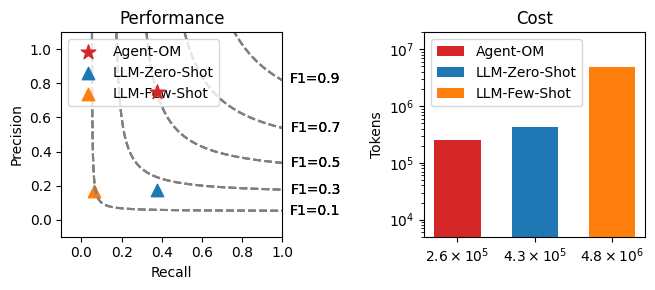

In [6]:
draw_and_save("result_csv/result-different-architecture-performance.csv", 
              "result_csv/result-different-architecture-cost.csv", 
              "result_figure/different-architecture.png", "tab10")

### LLMs

In [7]:
def generate_llm_evaluation(keyword, result_path):
    df = pd.read_csv('result_csv/result-anatomy-llm.csv')
    # filter rows where the "Alignment" column ends with "llm_with_agent"
    filtered_df = df[df['Alignment'].str.endswith(keyword)].copy()
    # add a new column "Name" with values from the "LLM" column
    filtered_df.loc[:, 'Name'] = filtered_df['LLM'].replace({
        'gpt-4o-2024-05-13': 'gpt-4o',
        'gpt-4o-mini-2024-07-18': 'gpt-4o-mini',
        'claude-3-sonnet-20240229': 'claude-3-sonnet',
        'claude-3-haiku-20240307': 'claude-3-haiku',
        'mistral-small-2402': 'mistral-small',
        'mistral:7b': 'mistral-7b',
        'llama3:8b': 'llama-3-8b',
        'llama3:instruct': 'llama-3-8b-instruct',
        'gemma2:9b': 'gemma-2-9b',
        'qwen2:7b': 'qwen-2-7b',
    })
    # drop the "Alignment" column
    filtered_df = filtered_df.drop(columns=['LLM', 'Alignment'])
    # save the modified DataFrame to a new CSV file
    filtered_df.to_csv(result_path, index=False)

In [8]:
generate_llm_evaluation('llm_with_agent', 'result_csv/result-anatomy-llm-trivial.csv')
generate_llm_evaluation('llm_with_agent_filter', 'result_csv/result-anatomy-llm-non-trivial.csv')

In [9]:
def draw_and_save(left_csv, right_csv, title_left, title_right, output_png, color_selection,
                  min_f1_1, max_f1_1, num_f1_1, min_f1_2, max_f1_2, num_f1_2):

    # load data
    df1 = pd.read_csv(left_csv)
    df2 = pd.read_csv(right_csv)

    df1['Precision'] = df1['Precision'] / 100
    df1['Recall'] = df1['Recall'] / 100
    df1 = df1.iloc[df1.apply(custom_sort, axis=1).argsort()]

    df2['Precision'] = df2['Precision'] / 100
    df2['Recall'] = df2['Recall'] / 100
    df2 = df2.iloc[df2.apply(custom_sort, axis=1).argsort()]
    
    # combine unique model names from both datasets
    combined_names = pd.concat([df1['Name'], df2['Name']]).unique().tolist()

    # set marker size
    marker_size = 80
    new_marker_size = 120

    color_map_updated = {new_matcher: new_matcher_color}
    # loop through combined_names to assign colors from colors_hex_list_20, except for "Agent-OM"
    for i, name in enumerate(combined_names):
        if name != new_matcher:  # Skip "Agent-OM" since it's already assigned
            if color_selection == "tab10":
                color_map_updated[name] = colors_hex_list_10[i-1 % len(colors_hex_list_10)]
            if color_selection == "tab20":
                color_map_updated[name] = colors_hex_list_20[i-1 % len(colors_hex_list_20)]

    # create the plot with updated color map
    fig, axs = plt.subplots(1, 2, figsize=(7.5, 3))

    # turn off the grid
    axs[0].grid(False)
    axs[1].grid(False)

    # set specific values for x-axis and y-axis ticks
    tick_values_1 = [0.85, 0.9, 0.95, 1.0]
    axs[0].set_xticks(tick_values_1)
    axs[0].set_yticks(tick_values_1)
    tick_values_2 = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    axs[1].set_xticks(tick_values_2)
    axs[1].set_yticks(tick_values_2)

    # adjust font size for x-axis and y-axis labels
    for ax in axs:
        ax.tick_params(axis='x', labelsize=10)  # Adjust x-axis label font size
        ax.tick_params(axis='y', labelsize=10)  # Adjust y-axis label font size

    # adjust the spacing between the subplots
    fig.subplots_adjust(wspace=0.3)  # Increase the space between subplots
    # adjust the subplot parameters to give some space for the legends
    plt.subplots_adjust(top=0.75)

    # initialize the zorder value
    initial_zorder = 50
    
    for name, group in df1.groupby('Name'):
        if name == new_matcher:
            axs[0].scatter(group['Recall'], group['Precision'], label=name, color='#D62728',
                           s=new_marker_size, marker='*', zorder=99)
        else:
            axs[0].scatter(group['Recall'], group['Precision'], label=name, color=color_map_updated[name],
                      s=marker_size, marker='^', zorder=initial_zorder)
            initial_zorder -= 1
        # calculate and plot the iso-F1 curves
        f1_levels = np.linspace(0.1, max_f1_1, num=num_f1_1)
        for f1 in f1_levels:
            x = np.linspace(0.001, 1, 1000)
            y = f1 * x / (2 * x - f1)
            valid_idx = np.where(y >= 0)  # valid indices where y is non-negative
            axs[0].plot(x[valid_idx], y[valid_idx], color='grey', alpha=1, linestyle='--', zorder=1)
            axs[0].annotate('F1={0:0.2f}'.format(f1), xy=(x[-1], y[-10]), textcoords="offset points", 
                            xytext=(25, -3), ha='center')

    axs[0].set_title(title_left)
    axs[0].set_xlim([min_f1_1, 1])
    axs[0].set_ylim([min_f1_1, 1.1])
    axs[0].set_xlabel('Recall', fontsize=10)
    axs[0].set_ylabel('Precision', fontsize=10)

    # initialize the zorder value
    initial_zorder = 50

    for name, group in df2.groupby('Name'):
        if name == new_matcher:
            axs[1].scatter(group['Recall'], group['Precision'], label=name, color='#D62728',
                           s=new_marker_size, marker='*', zorder=99)
        else:   
            axs[1].scatter(group['Recall'], group['Precision'], label=name, color=color_map_updated[name],
                           s=marker_size, marker='^', zorder=initial_zorder)
            initial_zorder -= 1
        # calculate and plot the iso-F1 curves
        f1_levels = np.linspace(0.1, max_f1_2, num=num_f1_2)
        for f1 in f1_levels:
            x = np.linspace(0.001, 1, 1000)
            y = f1 * x / (2 * x - f1)
            valid_idx = np.where(y >= 0)  # valid indices where y is non-negative
            axs[1].plot(x[valid_idx], y[valid_idx], color='grey', alpha=1, linestyle='--', zorder=1)
            axs[1].annotate('F1={0:0.2f}'.format(f1), xy=(x[-10], y[-10]), textcoords="offset points", 
                            xytext=(25, -3), ha='center')

    axs[1].set_title(title_right)
    axs[1].set_xlim([min_f1_2, 1])
    axs[1].set_ylim([min_f1_2, 1.1])
    axs[1].set_xlabel('Recall', fontsize=10)
    axs[1].set_ylabel('Precision', fontsize=10)

    # axs[0].set_ylabel('Scores')
    # for ax in axs:
    #     ax.set_xlabel('Metrics')
    #     ax.grid(True)

    # create custom handles for the unified legend with colors
    # handle the first name separately with marker="*"
    handles = [plt.Line2D([0], [0], marker='*', linestyle='None', markersize=10, label=combined_names[0], color=color_map_updated[combined_names[0]])]
    # handle the rest of the names with marker="^"
    handles += [plt.Line2D([0], [0], marker='^', linestyle='None', markersize=10, label=name, color=color_map_updated[name]) for name in combined_names[1:]]
    
    # handles = [plt.Line2D([0], [0], marker='^', linestyle='None', markersize=10, label=name, 
    #            color=color_map_updated[name]) for name in combined_names]

    # add the legend
    # create a legend for 'Agent-OM', aligned to the left above the figure
    # legend_a = fig.legend(handles=[handles[0]], loc='upper left', bbox_to_anchor=(0.02, 0.05), ncol=1, frameon=False)
    # create a second legend for the rest, aligned to the right above the figure
    # fig.legend(handles=handles[1:], loc='upper left', bbox_to_anchor=(0.2, 0.05), 
    #           ncol=4, frameon=True, labelspacing=0.5, columnspacing=0.5)
    fig.legend(handles, combined_names, loc='upper center', bbox_to_anchor=(0.5, 0.05), 
                ncol=5, frameon=True, labelspacing=0.5, columnspacing=0.5)

    # adjust the plot
    plt.tight_layout()
    # save the plot
    plt.savefig(output_png, bbox_inches='tight', pad_inches=0.1)
    # show the plot
    plt.show()

In [10]:
# define the custom order
custom_order = ['gpt-4o', 'gpt-4o-mini', 
                'claude-3-sonnet','claude-3-haiku', 
                'mistral-small', 'mistral-7b', 
                'llama-3-8b', 'llama-3-8b-instruct',
                'gemma-2-9b', 'qwen-2-7b']
# create a dictionary to map names to their custom order
order_dict = {name.lower(): index for index, name in enumerate(custom_order)}

# define the custom sort function
def custom_sort(row):
    name = row['Name'].lower()
    # return the index of the name in the custom order if it exists
    # otherwise return a large number to push it to the end
    return order_dict.get(name, float('inf'))

In [11]:
# set new matcher
new_matcher = "gpt-4o"
new_matcher_color = "#d62728"

/tmp/ipykernel_2898077/158577060.py:72: RuntimeWarning: divide by zero encountered in divide
  y = f1 * x / (2 * x - f1)
/tmp/ipykernel_2898077/158577060.py:99: RuntimeWarning: divide by zero encountered in divide
  y = f1 * x / (2 * x - f1)


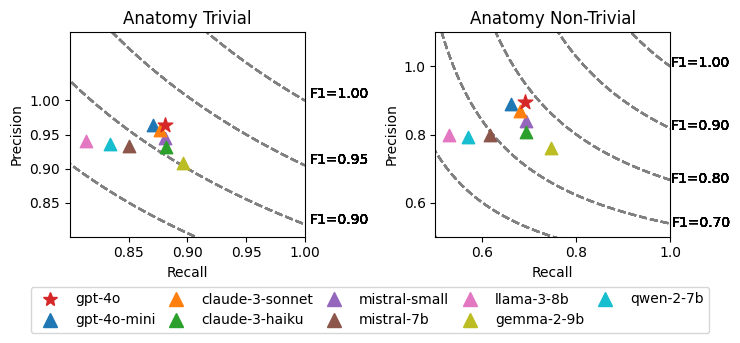

In [12]:
draw_and_save('result_csv/result-anatomy-llm-trivial.csv', 'result_csv/result-anatomy-llm-non-trivial.csv', 
              "Anatomy Trivial", "Anatomy Non-Trivial", "result_figure/anatomy-llm.png", "tab10", 
              0.8, 1.0, 19, 0.5, 1.0, 10)

### Hybrid Database

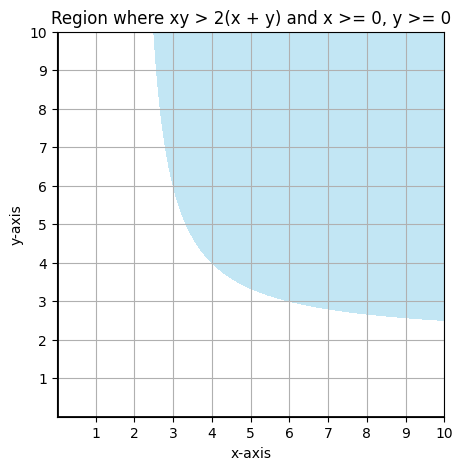

In [13]:
# define the range for x and y
x = np.linspace(0, 10, 400)
y = np.linspace(0, 10, 400)

# create a meshgrid for x and y
X, Y = np.meshgrid(x, y)

# define the inequality xy > 2(x + y)
inequality = X * Y - 2 * (X + Y)

# plot the region where the inequality is satisfied
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, inequality, levels=[0, np.inf], colors='skyblue', alpha=0.5)

# add labels and title
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Region where xy > 2(x + y) and x >= 0, y >= 0')

# set custom ticks for x-axis and y-axis
plt.xticks(np.arange(1, 11))
plt.yticks(np.arange(1, 11))

# show the plot
plt.grid(True)
plt.axhline(0, color='black', lw=2)
plt.axvline(0, color='black', lw=2)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

### Matching Validator

In [14]:
def draw_and_save_validation(file_name, measure, output_png):
    # read file
    df = pd.read_csv(file_name)
    df['Precision'] = df['Precision'] / 100
    df['Recall'] = df['Recall'] / 100
    df['F1 Score'] = df['F1'] / 100
    # categorize data based on the ending of the 'Alignment' strings
    df['Category'] = df['Alignment'].apply(lambda x: 'Without VAL' if x.endswith('component/no_validation') 
                                           else ('With VAL' if x.endswith('component/llm_with_agent') 
                                           else 'Unknown'))
    # set colors for each category
    colors = [colors_hex_list_10[0], colors_hex_list_10[1]]
    categories = ['Without VAL', 'With VAL']
    # calculate positions for each category to place them on the x-axis
    positions = np.arange(1, len(categories) + 1)
    # adjust jitter for better visibility
    jitter = 0.15
    np.random.seed(42)
    # marker size
    marker_size = 50
    # calculate the maximum size of any category
    max_size = df['Category'].value_counts().max()
    # generate jitter values based on the maximum size
    jitter_values = np.random.normal(0, jitter, size=max_size)
    
    # figure size
    fig, ax = plt.subplots(figsize=(2.5, 3))
    # plotting each category with jitter
    for pos, category, color in zip(positions, categories, colors):
        # extract the precision values for the current category
        precision_values = df[measure][df['Category'] == category].values
        # apply jitter: randomly adjust the x position slightly to reduce overlap
        current_size = len(precision_values)
        jittered_x = pos + jitter_values[:current_size]
        # jittered_x = pos + np.random.normal(0, jitter, size=len(precision_values))
        ax.scatter(jittered_x, precision_values, color=color, alpha=0.7, label=category, s=marker_size)
        
    # customizing the plot
    ax.set_title(measure)
    # ax.set_xlabel('Category')
    # ax.set_ylabel(measure)
    ax.set_xticks(positions)
    ax.set_xticklabels(categories)
    ax.set_xlim(0.5, len(categories) + 0.5)
    ax.set_ylim([-0.05, 1.05])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    # ax.legend()
    
    plt.savefig(output_png, bbox_inches='tight', pad_inches=0.1)
    
    plt.show()

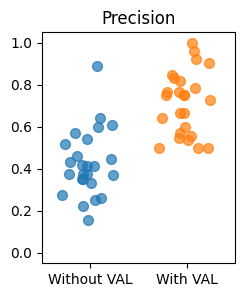

In [15]:
draw_and_save_validation("result_csv/result-reference.csv", "Precision", "result_figure/validation-precision.png")

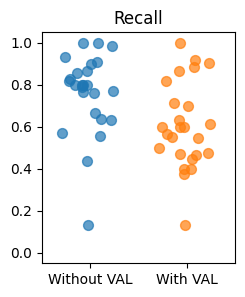

In [16]:
draw_and_save_validation("result_csv/result-reference.csv", "Recall", "result_figure/validation-recall.png")

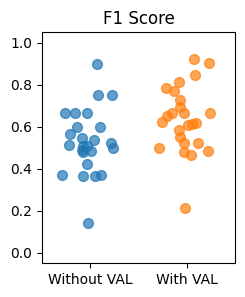

In [17]:
draw_and_save_validation("result_csv/result-reference.csv", "F1 Score", "result_figure/validation-f1.png")

### Matching Merger

In [18]:
def draw_and_save_merge(file_name, measure, output_png):
    # read file
    df = pd.read_csv(file_name)
    df['Precision'] = df['Precision'] / 100
    df['Recall'] = df['Recall'] / 100
    df['F1 Score'] = df['F1'] / 100
    # categorise data based on the ending of the 'Alignment' strings
    df['Category'] = df['Alignment'].apply(lambda x: '$O_s \Rightarrow O_t$' if x.endswith('component/source') 
                                           else ('$O_s \Leftarrow O_t$' if x.endswith('component/target') 
                                           else ('$O_s \Leftrightarrow O_t$' if x.endswith('component/llm_with_agent') 
                                           else 'Unknown')))
    
    # set colors for each category
    colors = [colors_hex_list_10[0], colors_hex_list_10[1], colors_hex_list_10[2]]
    categories = ['$O_s \Rightarrow O_t$', '$O_s \Leftarrow O_t$', '$O_s \Leftrightarrow O_t$']
    # calculate positions for each category to place them on the x-axis
    positions = np.arange(1, len(categories) + 1)
    # adjust jitter for better visibility
    jitter = 0.15
    np.random.seed(42)
    # set marker size
    marker_size = 50
    # calculate the maximum size of any category
    max_size = df['Category'].value_counts().max()
    # generate jitter values based on the maximum size
    jitter_values = np.random.normal(0, jitter, size=max_size)
    
    # set figure size
    fig, ax = plt.subplots(figsize=(2.5, 3))
    # plot each category with jitter
    for pos, category, color in zip(positions, categories, colors):
        # extract the precision values for the current category
        precision_values = df[measure][df['Category'] == category].values
        # apply jitter: randomly adjust the x position slightly to reduce overlap
        current_size = len(precision_values)
        jittered_x = pos + jitter_values[:current_size]
        # jittered_x = pos + np.random.normal(0, jitter, size=len(precision_values))
        ax.scatter(jittered_x, precision_values, color=color, alpha=0.7, label=category, s=marker_size)
        
    # customise the plot
    ax.set_title(measure)
    # ax.set_xlabel('Category')
    # ax.set_ylabel(measure)
    ax.set_xticks(positions)
    ax.set_xticklabels(categories)
    ax.set_xlim(0.5, len(categories) + 0.5)
    ax.set_ylim([-0.05, 1.05])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    # ax.legend()
    
    plt.savefig(output_png, bbox_inches='tight', pad_inches=0.1)
    
    plt.show()

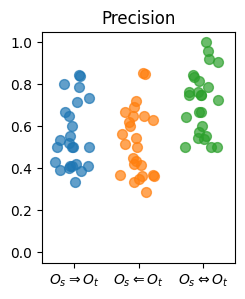

In [19]:
draw_and_save_merge("result_csv/result-reference.csv", "Precision", "result_figure/merge-precision.png")

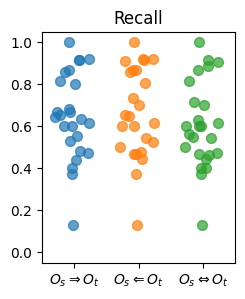

In [20]:
draw_and_save_merge("result_csv/result-reference.csv", "Recall", "result_figure/merge-recall.png")

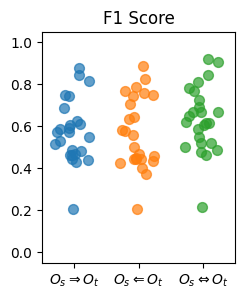

In [21]:
draw_and_save_merge("result_csv/result-reference.csv", "F1 Score", "result_figure/merge-f1.png")

### Similarity Threshold

In [22]:
df = pd.read_csv("result_csv/result-cmt-confof-similarity.csv")
# filter rows where the "Alignment" column ends with a number
df = df[df['Alignment'].str.match(r'.*-llm_with_agent')]
# extract decimal numbers from 0.1 to 1.0 in the "Alignment" column
df['Alignment'] = df['Alignment'].str.extract('(0\.[1-9][0-9]?|1\.0)')
# convert the "Alignment" column to numeric
df['Alignment'] = pd.to_numeric(df['Alignment'], errors='coerce')
# sort the DataFrame by the "Alignment" column in descending order, if needed
df = df.sort_values(by='Alignment', ascending=False)
# set values [0,1]
df['Precision'] = df['Precision'] / 100
df['Recall'] = df['Recall'] / 100
df.rename(columns={'F1': 'F1 Score'}, inplace=True)
df['F1 Score'] = df['F1 Score'] / 100
# set 'Alignment' as the index
df.set_index('Alignment', inplace=True)
df

,LLM,Precision,Recall,F1 Score
Alignment,,,,
1.00,gpt-4o-mini-2024-07-18,0.5000,0.1250,0.2000
0.95,gpt-4o-mini-2024-07-18,0.7143,0.3125,0.4348
0.90,gpt-4o-mini-2024-07-18,0.7500,0.3750,0.5000
0.85,gpt-4o-mini-2024-07-18,0.5556,0.3125,0.4000
0.75,gpt-4o-mini-2024-07-18,0.5556,0.3125,0.4000
0.70,gpt-4o-mini-2024-07-18,0.5556,0.3125,0.4000
0.65,gpt-4o-mini-2024-07-18,0.5556,0.3125,0.4000
0.60,gpt-4o-mini-2024-07-18,0.5556,0.3125,0.4000
0.55,gpt-4o-mini-2024-07-18,0.5556,0.3125,0.4000


In [23]:
def draw_and_save_similarity(output_png):

    df[['Precision', 'Recall', 'F1 Score']].plot(kind='line', marker='o', figsize=(6, 1.5),color=colors_hex_list_10)
    # plt.figure(figsize=(10, 2))
    # plt.plot(df['Alignment'], df[measure], marker='o', linestyle='-', linewidth=2, color=colors_hex_list_10[color_order])

    # set x-axis label
    plt.xlabel('Similarity Threshold')
    # set y-axis label
    # plt.ylabel(measure)
    # show grid lines
    # plt.grid(True)

    # invert the x-axis to have 1.0 on the left and 0.1 on the right
    plt.gca().invert_xaxis()

    # set x-axis range
    plt.xticks(np.arange(1.0, 0.45, -0.05))
    # set y-axis range
    plt.yticks(np.arange(0.0, 1.1, 0.2))
    # set legend
    plt.legend(loc='upper left', bbox_to_anchor=(-0.35, 0.8), frameon=False)
    # save the figure
    plt.savefig(output_png, bbox_inches='tight', pad_inches=0.1)
    # plot the figure
    plt.show()

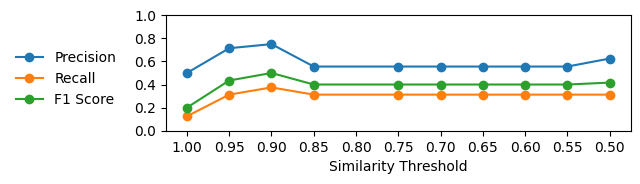

In [24]:
draw_and_save_similarity("result_figure/similarity.png")